Some libraries to import

In [14]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
import numpy as np
import keras_tuner as kt

Choosing to work with the GPU for faster training

In [15]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')  # Use only the first GPU
    except RuntimeError as e:
        print(e)

Importing data

In [16]:
commands = []

with open('data.txt', 'r') as file:
    for line in file:
      if line:
        commands.append(line.strip())

# commands

Tokenization

In [17]:
tokenizer = Tokenizer(filters='')
tokenizer.fit_on_texts(commands)

Sequencing

In [18]:
sequences = tokenizer.texts_to_sequences(commands)
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1

Input Output sequences

In [19]:
input_sequences = []
target_sequences = []

for seq in sequences:
    for i in range(1, len(seq)):
        input_sequences.append(seq[:i])
        target_sequences.append(seq[i])

Padding

In [20]:
max_seq_len = max(len(seq) for seq in input_sequences)
input_sequences = pad_sequences(input_sequences, maxlen=max_seq_len, padding='post')
target_sequences = np.array(target_sequences)

Train_text spliting

In [21]:
x_train, x_test, y_train, y_test = train_test_split(input_sequences,target_sequences, test_size=0.2)

Model building function

In [22]:
def my_model(hp):    
    model = Sequential([
        Embedding(
            input_dim=vocab_size, 
            output_dim=hp.Choice('embedding_dim', [64,128,256])
        ),
        LSTM(
            units=hp.Choice('lstm_units', [32, 64, 128]), 
            return_sequences=False
        ),
        Dropout(
            rate=hp.Float('dropout_rate', 0.2, 0.5, step=0.1)
        ),
        Dense(
            vocab_size, 
            activation=hp.Choice('activation', ['softmax', 'sigmoid'])
        )
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])), 
        loss='sparse_categorical_crossentropy', 
        metrics=[tf.keras.metrics.SparseTopKCategoricalAccuracy(k=hp.Choice("top_k", [3, 5]))]
    )
    model.summary()
    return model

Tuner initialization

In [23]:
tuner = kt.Hyperband(
    my_model,
    objective=kt.Objective("val_sparse_top_k_categorical_accuracy", direction="max"),
    max_epochs=30,
    factor=3,
    directory='my_dir',
    project_name='command_completion'
)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Early Stopping callback

In [24]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

Searching for the best hyperparameters

In [25]:
tuner.search(
    x_train, 
    y_train, 
    epochs=60, 
    validation_split=0.2, 
    callbacks=[stop_early],
    batch_size=tuner.oracle.hyperparameters.Choice('batch_size', [16, 32, 64])
)

Trial 90 Complete [00h 01m 05s]
val_sparse_top_k_categorical_accuracy: 0.6630573272705078

Best val_sparse_top_k_categorical_accuracy So Far: 1.0
Total elapsed time: 00h 13m 22s


In [26]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
Best embedding_dim: \t{best_hps.get('embedding_dim')}
Best lstm_units: \t{best_hps.get('lstm_units')}
Best dropout_rate: \t{best_hps.get('dropout_rate')}
Best activation function: \t{best_hps.get('activation')}
Best learning_rate: \t{best_hps.get('learning_rate')}
Best batch_size: \t{best_hps.get('batch_size')}
Best k for accuracy: \t{best_hps.get('top_k')}

""")


Best embedding_dim: 	128
Best lstm_units: 	64
Best dropout_rate: 	0.30000000000000004
Best activation function: 	relu
Best learning_rate: 	0.01
Best batch_size: 	16
Best k for accuracy: 	3




Training the model using the best hyperparameters we got

In [27]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)
history = model.fit(x_train, y_train, epochs=100, batch_size=16, verbose=1, validation_data=(x_test, y_test))

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
491/491 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 7.9310 - sparse_top_k_categorical_accuracy: 0.8954 - val_loss: 7.1033 - val_sparse_top_k_categorical_accuracy: 1.0000
Epoch 2/100
491/491 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 7.1063 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 7.1033 - val_sparse_top_k_categorical_accuracy: 1.0000
Epoch 3/100
491/491 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 7.1100 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 7.1033 - val_sparse_top_k_categorical_accuracy: 1.0000
Epoch 4/100
491/491 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 7.1110 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 7.1033 - val_sparse_top_k_categorical_accuracy: 1.0000
Epoch 5/100
491/491 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 7.1059 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 7.1033 - val_sparse_top_k_categorical_accuracy: 1.0000
Epoch 6/100
491/491 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 7.1034 - sparse_top_k_categorical_accuracy: 

Storing the history of training into variables

In [28]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
# train_accuracy = history.history['accuracy']
# val_accuracy = history.history['val_accuracy']
train_accuracy = history.history['sparse_top_k_categorical_accuracy']
val_accuracy = history.history['val_sparse_top_k_categorical_accuracy']

epochs = range(1, len(train_loss) + 1)

Plotting a result graph 

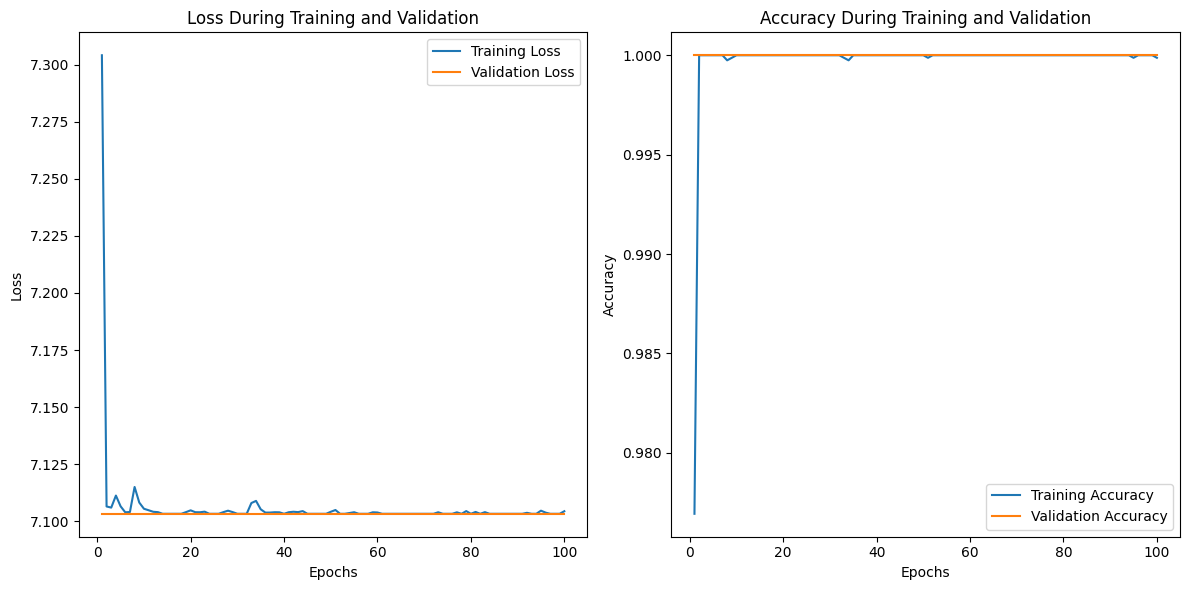

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Loss During Training and Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Accuracy During Training and Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Saving the hyperparameters

In [30]:
import configparser

# Create a ConfigParser instance
config = configparser.ConfigParser()

# Add a section for hyperparameters
config.add_section('Hyperparameters')

# Store the best hyperparameters in the section
config.set('Hyperparameters', 'embedding_dim', str(best_hps.get('embedding_dim')))
config.set('Hyperparameters', 'lstm_units', str(best_hps.get('lstm_units')))
config.set('Hyperparameters', 'activation', str(best_hps.get('activation')))
config.set('Hyperparameters', 'dropout_rate', str(best_hps.get('dropout_rate')))
config.set('Hyperparameters', 'learning_rate', str(best_hps.get('learning_rate')))
config.set('Hyperparameters', 'batch_size', str(best_hps.get('batch_size')))
config.set('Hyperparameters', 'top_k', str(best_hps.get('top_k')))

# Write the configuration to a file
with open('best_hyperparameters.ini', 'w') as configfile:
    config.write(configfile)


Testing parameter loading

In [31]:
################
# reading 
################
config = configparser.ConfigParser()
config.read('best_hyperparameters.ini')

# Access hyperparameters
embedding_dim = config.getint('Hyperparameters', 'embedding_dim')
lstm_units = config.getint('Hyperparameters', 'lstm_units')
dropout_rate = config.getfloat('Hyperparameters', 'dropout_rate')
learning_rate = config.getfloat('Hyperparameters', 'learning_rate')
batch_size = config.getint('Hyperparameters', 'batch_size')

print(f"embedding_dim: {embedding_dim}")
print(f"lstm_units: {lstm_units}")
print(f"dropout_rate: {dropout_rate}")
print(f"learning_rate: {learning_rate}")
print(f"batch_size: {batch_size}")


embedding_dim: 128
lstm_units: 64
dropout_rate: 0.30000000000000004
learning_rate: 0.01
batch_size: 16


Parameters dictionnary

Creating kerasClassifier to wrapp our model 

RandomSearchCV from best parameters

Fitting to data

Extraction statistics

Graphs

Saving the model

Saving the tokenizer